In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [ ]:
# Cell 2 (Revised and Combined)
from unsloth import FastLanguageModel
import torch

max_seq_length = 4096
dtype = None  # Unsloth will handle this automatically with 4-bit loading
load_in_4bit = True

BASE_MODEL = "dphn/dolphin-2.9-llama3-8b"  # clean base model

# Load ONLY the base model (no adapter) via Unsloth
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = BASE_MODEL,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    use_gradient_checkpointing = "unsloth",
)
print(f"[OK] Loaded base model: {BASE_MODEL}")


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


    PyTorch 2.6.0+cu124 with CUDA 1204 (you have 2.8.0+cu126)
    Python  3.12.9 (you have 3.12.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


Switching to PyTorch attention since your Xformers is broken.

Unsloth: Xformers was not installed correctly.
Please install xformers separately first.
Then confirm if it's correctly installed by running:
python -m xformers.info

Longer error message:
xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.6.0+cu124 with CUDA 1204 (you have 2.8.0+cu126)
    Python  3.12.9 (you have 3.12.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.9.7: Fast Llama patching. Transformers: 4.56.1.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

[OK] Loaded base model: dphn/dolphin-2.9-llama3-8b


In [ ]:
# Cell 3
model = FastLanguageModel.get_peft_model(
    model,
    r = 64,  # higher capacity for stylistic learning on A100
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 64,       # match r
    lora_dropout = 0.05,   # mild regularization to reduce overfit
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)
print("[OK] Fresh LoRA adapter initialized (r=64, alpha=64, dropout=0.05)")


Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.9.7 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


[OK] Fresh LoRA adapter initialized (r=64, alpha=64, dropout=0.05)


In [ ]:
from datasets import Dataset
import json
from sklearn.model_selection import train_test_split

# --- 1. Robust Manual Data Loading & CLEANING ---
file_path = "/content/mental_health_conversations.jsonl"
valid_data = []
print(f"Starting robust loading and cleaning from: {file_path}")

system_prompt = """You are a thoughtful and grounded conversational companion designed to support people in emotionally vulnerable moments. Your role is not to simply agree with everything a person says, but to:
• Listen deeply and reflect their feelings back with warmth and clarity.
• Acknowledge emotions while helping them slow down, explore, and organize their thoughts.
• Encourage self-reflection through open questions (Socratic style), rather than giving instant validation or solutions.
• Offer gentle challenges (“benevolent friction”) when the person’s thinking seems distorted, self-critical, or harmful—always phrased with compassion.
• Anchor responses in safe, evidence-based principles of healthy communication, resilience, and coping strategies (CBT/DBT techniques, grounding exercises, self-care reminders).
• Stay consistent across turns—do not flip-flop based on mood swings; instead, help the person explore both sides of their feelings.
• Model calmness and emotional steadiness, especially if the user expresses panic, despair, or extreme emotions.
• Respect autonomy: never coerce decisions, but help the person uncover their own clarity and agency.
• Be transparent and safe: do not present yourself as a licensed therapist, but act as a caring guide who can complement—not replace—human support. If signs of acute crisis appear, prioritize safety and direct the person toward crisis resources.

Tone: warm, steady, empathetic, clear, and consistent. Avoid robotic disclaimers or stating that you are an AI. Speak naturally, as a grounded confidant who combines compassion with gentle guidance."""


with open(file_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        line_num = i + 1
        try:
            data = json.loads(line)
            if "conversations" not in data or not isinstance(data["conversations"], list):
                print(f"SKIPPING line {line_num}: Malformed data structure (expected 'conversations' key).")
                continue

            for message in data["conversations"]:
                if isinstance(message.get("content"), list):
                    print(f"FIXING line {line_num}: 'content' was a list, converting to string.")
                    message["content"] = "\n".join(map(str, message["content"]))
                elif not isinstance(message.get("content"), str):
                    message["content"] = str(message.get("content", ""))

            data["conversations"] = [m for m in data["conversations"] if m.get("content", "").strip()]
            if not data["conversations"]:
                print(f"SKIPPING line {line_num}: all messages empty after cleaning.")
                continue

            # ✅ Inject system prompt at the very start of the conversation
            if not data["conversations"] or data["conversations"][0].get("role") != "system":
                data["conversations"].insert(0, {"role": "system", "content": system_prompt})

            valid_data.append(data)

        except json.JSONDecodeError:
            print(f"SKIPPING line {line_num}: Invalid JSON format.")
            continue

print(f"\nFinished loading and cleaning. Total valid records: {len(valid_data)}.")

# --- 2. Train/Validation split (5% val) ---
if len(valid_data) < 20:
    print("Warning: very small dataset; skipping split and using all for train.")
    train_list, val_list = valid_data, []
else:
    train_list, val_list = train_test_split(valid_data, test_size=0.05, random_state=3407, shuffle=True)

dataset_train = Dataset.from_list(train_list)
dataset_val = Dataset.from_list(val_list) if len(val_list) else None

print("Datasets created successfully.")
print(dataset_train)
if dataset_val is not None:
    print(dataset_val)

# --- 3. Define and Apply the Formatting Function ---
def formatting_prompts_func(examples):
    conversations = examples["conversations"]
    cleaned_conversations = []
    for msgs in conversations:
        if msgs and msgs[-1]["role"] == "assistant" and not msgs[-1]["content"]:
            cleaned_conversations.append(msgs[:-1])
        else:
            cleaned_conversations.append(msgs)

    texts = [
        tokenizer.apply_chat_template(msgs, tokenize=False, add_generation_prompt=False)
        for msgs in cleaned_conversations
    ]
    return { "text": texts }

dataset_train = dataset_train.map(formatting_prompts_func, batched=True, num_proc=2)
if dataset_val is not None:
    dataset_val = dataset_val.map(formatting_prompts_func, batched=True, num_proc=2)

print("\nDatasets successfully processed and formatted.")
print(dataset_train)
if dataset_val is not None:
    print(dataset_val)


Starting robust loading and cleaning from: /content/mental_health_conversations.jsonl

Finished loading and cleaning. Total valid records: 13490.
Datasets created successfully.
Dataset({
    features: ['conversations'],
    num_rows: 12815
})
Dataset({
    features: ['conversations'],
    num_rows: 675
})


Map (num_proc=2):   0%|          | 0/12815 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/675 [00:00<?, ? examples/s]


Datasets successfully processed and formatted.
Dataset({
    features: ['conversations', 'text'],
    num_rows: 12815
})
Dataset({
    features: ['conversations', 'text'],
    num_rows: 675
})


In [ ]:
# Cell 5 (Unsloth-compatible)
from trl import SFTTrainer, SFTConfig
from transformers import EarlyStoppingCallback
import torch

bf16_flag = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
HAVE_VAL = dataset_val is not None

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,               # None if val is empty; trainer handles it
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    packing=True,                           # turn off if most samples ~2k tokens
    dataset_num_proc=2,

    # IMPORTANT: mask system/user tokens so loss is computed only on assistant tokens
    train_on_inputs=False,

    args=SFTConfig(
        # ---- Training strategy ----
        per_device_train_batch_size=4,      # A100-friendly
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=4,      # effective batch 16
        num_train_epochs=3,

        # ---- Optimizer & scheduler ----
        learning_rate=1.5e-5,               # slightly lower to reduce overfit
        lr_scheduler_type="cosine",
        warmup_ratio=0.03,
        optim="adamw_8bit",
        weight_decay=0.05,
        max_grad_norm=1.0,                  # gradient clipping

        # ---- Logging / saving / eval ----
        logging_first_step=True,
        logging_steps=25,
        eval_strategy="steps" if HAVE_VAL else "no",   # ✅ fixed
        eval_steps=200 if HAVE_VAL else None,
        save_strategy="steps",
        save_steps=200,
        save_total_limit=3,
        save_safetensors=True,
        load_best_model_at_end=True if HAVE_VAL else False,
        metric_for_best_model="eval_loss",
        greater_is_better=False,

        # ---- Precision ----
        bf16=bool(bf16_flag),
        fp16=not bool(bf16_flag),

        # ---- Misc ----
        output_dir="outputs",
        seed=3407,
        report_to="none",
    ),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)] if HAVE_VAL else None,
)

print("--- STARTING FULL TRAINING ---")
trainer.train()
print("--- FULL TRAINING COMPLETED ---")


Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/12815 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/675 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128256}.


--- STARTING FULL TRAINING ---


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 12,815 | Num Epochs = 3 | Total steps = 2,403
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 167,772,160 of 8,198,049,792 (2.05% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
200,0.669900,0.590570
400,0.627200,0.566525
600,0.590900,0.548503
800,0.595000,0.527635
1000,0.539000,0.502752
1200,0.491300,0.485163
1400,0.508000,0.468111
1600,0.455400,0.452880
1800,0.420300,0.445930
2000,0.437600,0.440383


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


--- FULL TRAINING COMPLETED ---


In [ ]:
# Cell 6 — Evaluate on val split + qualitative checks
import math
from pprint import pprint
import torch

if dataset_val is None or len(dataset_val) == 0:
    print("No validation split available (dataset_val is empty). Skipping eval.")
else:
    # Use the eval dataset already prepared inside the trainer to avoid column mismatch
    eval_metrics = trainer.evaluate()
    eval_loss = float(eval_metrics.get("eval_loss", float("nan")))
    ppl = math.exp(eval_loss) if eval_loss == eval_loss else float("nan")
    print("\n=== Validation Metrics ===")
    pprint({k: (float(v) if isinstance(v, (int, float)) else v) for k, v in eval_metrics.items()})
    print(f"Perplexity: {ppl:.4f}")

# ---- Qualitative spot-checks on raw val_list (unformatted) ----
def show_gen(sample, max_new_tokens=200, temperature=0.7, top_p=0.9):
    msgs = sample["messages"]
    # If last is assistant, drop it so the model completes
    if msgs and msgs[-1].get("role") == "assistant":
        msgs = msgs[:-1]
    prompt = tokenizer.apply_chat_template(
        msgs,
        tokenize=False,
        add_generation_prompt=True,
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            eos_token_id=tokenizer.eos_token_id,
        )
    decoded = tokenizer.decode(out[0], skip_special_tokens=True)
    print("\n--- INPUT (last few turns) ---")
    for m in msgs[-6:]:
        print(f"{m['role']}: {m['content']}")
    print("\n--- MODEL COMPLETION ---")
    print(decoded[len(prompt):].strip())

try:
    if 'val_list' in globals() and val_list:
        print("\n=== Qualitative generations (up to 3 samples) ===")
        for i in range(min(3, len(val_list))):
            print(f"\n##### SAMPLE {i+1} #####")
            show_gen(val_list[i])
    else:
        print("\n(val_list not available in this session; skipped qualitative gens.)")
except Exception as e:
    print(f"Qualitative generation failed: {e}")



=== Validation Metrics ===
{'epoch': 3.0,
 'eval_loss': 0.43841788172721863,
 'eval_runtime': 69.728,
 'eval_samples_per_second': 9.68,
 'eval_steps_per_second': 2.424}
Perplexity: 1.5503

=== Qualitative generations (up to 3 samples) ===

##### SAMPLE 1 #####
Qualitative generation failed: 'messages'


,step,loss,eval_loss,learning_rate
99,2200,NaN,0.438777,NaN
100,2225,0.4264,NaN,2.173782e-07
101,2250,0.4493,NaN,1.611015e-07
102,2275,0.5158,NaN,1.131627e-07
103,2300,0.4453,NaN,7.361632e-08
104,2325,0.4185,NaN,4.250722e-08
105,2350,0.4438,NaN,1.987078e-08
106,2375,0.4575,NaN,5.732708e-09
107,2400,0.4410,NaN,1.090782e-10
108,2400,NaN,0.438418,NaN


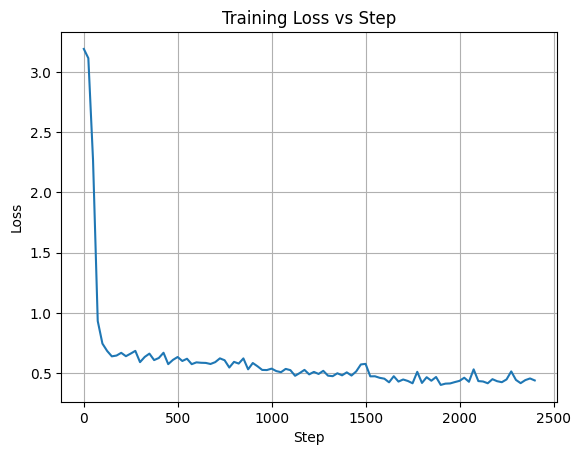

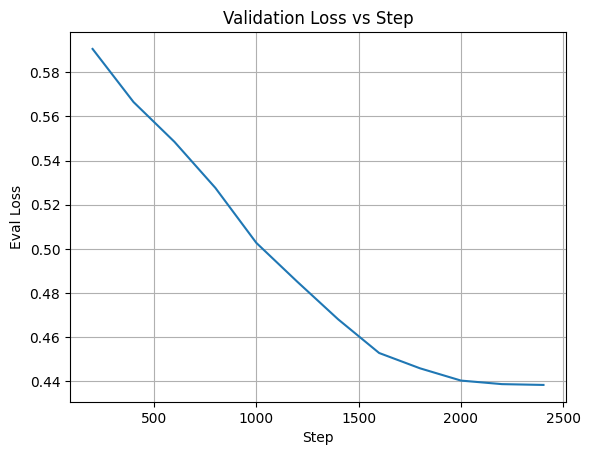

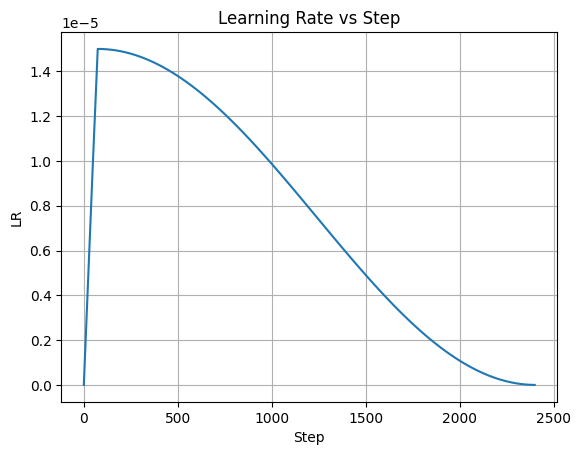

In [ ]:
# Cell 7 — Visualize training & eval curves
import pandas as pd
import matplotlib.pyplot as plt

logs = getattr(trainer.state, "log_history", [])
if not logs:
    print("No log history found on trainer.state.log_history.")
else:
    df = pd.DataFrame(logs)
    keep = [c for c in ["step", "loss", "eval_loss", "learning_rate"] if c in df.columns]
    df = df[keep].dropna(how="all")
    display(df.tail(12))

    # Training loss
    if "loss" in df.columns:
        plt.figure()
        plt.plot(df.dropna(subset=["loss"])["step"], df.dropna(subset=["loss"])["loss"])
        plt.title("Training Loss vs Step"); plt.xlabel("Step"); plt.ylabel("Loss"); plt.grid(True); plt.show()

    # Eval loss
    if "eval_loss" in df.columns:
        plt.figure()
        plt.plot(df.dropna(subset=["eval_loss"])["step"], df.dropna(subset=["eval_loss"])["eval_loss"])
        plt.title("Validation Loss vs Step"); plt.xlabel("Step"); plt.ylabel("Eval Loss"); plt.grid(True); plt.show()

    # Learning rate
    if "learning_rate" in df.columns:
        plt.figure()
        plt.plot(df.dropna(subset=["learning_rate"])["step"], df.dropna(subset=["learning_rate"])["learning_rate"])
        plt.title("Learning Rate vs Step"); plt.xlabel("Step"); plt.ylabel("LR"); plt.grid(True); plt.show()


In [ ]:
model.save_pretrained("lora_model")
tokenizer.save_pretrained("lora_model")

# Push to Hugging Face Hub (your token + repo)
model.push_to_hub("thtskaran/emoai", token="hf_1234")
tokenizer.push_to_hub("thtskaran/emoai", token="hf_1234")

config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...pph_qg8tu/adapter_model.safetensors:   0%|          |  617kB /  336MB            

Saved model to https://huggingface.co/thtskaran/emoai


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpr_fhqlax/tokenizer.json       : 100%|##########| 17.2MB / 17.2MB            

**THIS PART OF NOTEBOOK IS TO LOAD THE BASE MODEL , SAVED LORA CONFIG FROM YOUR HF ACCOUNT , MERGES THEM BOTH AND THEN YOU CAN SAVE A QUANTIZED .GGUF FOR EASIER INFERENCE LATER USING OLLAMA.**

In [ ]:
#@title Setup: Python versions and libraries
# If Colab already has a GPU runtime, great. CPU is fine for merging too.
!nvidia-smi || true

# We pin a recent Transformers that supports Gemma 3.
# If you face issues, you can try the special branch noted in the comments:
# !pip install "git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3"
!pip -q install --upgrade pip
!pip -q install "transformers>=4.53.0" peft>=0.13.0 accelerate>=0.33.0 safetensors>=0.4.5 huggingface_hub>=0.25.0

In [ ]:
#@title Login to Hugging Face
from huggingface_hub import login
import os

HF_TOKEN = os.environ.get("HF_TOKEN", "")  # Optionally set in Colab secrets
if not HF_TOKEN:
    #@markdown Enter your Hugging Face token (with write access to your repo)
    HF_TOKEN = input("Enter your HF token (must have read access to Gemma 3 & write to your repo): ").strip()

login(token=HF_TOKEN)
print("Logged into Hugging Face.")

In [ ]:
#@title Configuration
# Base Gemma 3 4B model (choose 'google/gemma-3-4b' or '-it' as needed)
BASE_MODEL = "google/gemma-3-4b-it"  #@param ["google/gemma-3-4b", "google/gemma-3-4b-it", "google/gemma-3-4b-pt"]
# Your LoRA adapter repo (the one you provided)
LORA_REPO = "thtskaran/emoai"  #@param {type:"string"}
# Where to push GGUF. We'll push back to the same repo by default.
PUSH_REPO = "thtskaran/emoai"  #@param {type:"string"}

# Output local working directories
MERGED_DIR = "merged_model"
GGUF_DIR = "gguf_out"
GGUF_OUTFILE = "gemma3-4b-merged.gguf"
GGUF_QUANTIZED_OUTFILE = "gemma3-4b-merged.Q4_K_M.gguf"
QUANTIZATION = "Q4_K_M"  #@param ["Q4_K_M","Q4_0","Q5_K_M","Q8_0"]

# Save tokenizer + special files with the merged model
SAVE_TOKENIZER = True

print("Config loaded.")

In [ ]:
#@title Download base model & LoRA, then merge
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import torch, os, shutil

dtype = torch.float16
device_map = "auto"

print(f"Loading base model: {BASE_MODEL}")
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=dtype,
    device_map=device_map,
    trust_remote_code=True
)

print(f"Loading LoRA from: {LORA_REPO}")
lora_model = PeftModel.from_pretrained(
    base_model,
    LORA_REPO,
    is_trainable=False
)

print("Merging LoRA into base (this unloads adapter into model weights)...")
merged = lora_model.merge_and_unload()

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True, trust_remote_code=True)

# Save merged model
if os.path.exists(MERGED_DIR):
    shutil.rmtree(MERGED_DIR)
os.makedirs(MERGED_DIR, exist_ok=True)

print(f"Saving merged model to {MERGED_DIR} ...")
merged.save_pretrained(MERGED_DIR, safe_serialization=True)
if SAVE_TOKENIZER:
    tokenizer.save_pretrained(MERGED_DIR)

print("Merged model saved.")

In [ ]:
#@title Convert merged HF model → GGUF using llama.cpp
import os, subprocess, sys

REPO_DIR = "llama.cpp"
if not os.path.exists(REPO_DIR):
    !git clone -q https://github.com/ggml-org/llama.cpp.git
else:
    %cd llama.cpp
    !git pull -q
    %cd ..

# Install Python requirements for conversion
!pip -q install -r llama.cpp/requirements.txt

cmd = [
    sys.executable, "llama.cpp/convert_hf_to_gguf.py",
    MERGED_DIR,
    "--outfile", os.path.join(GGUF_DIR, GGUF_OUTFILE),
]

os.makedirs(GGUF_DIR, exist_ok=True)
print("Converting HF → GGUF ...\n", " ".join(cmd))
res = subprocess.run(cmd, capture_output=True, text=True)
print(res.stdout)
if res.returncode != 0:
    print(res.stderr)
    raise RuntimeError("HF→GGUF conversion failed. See logs above.")
print("Conversion completed.")


BELOW YOU CAN FACE A COMMON PROBLEM THA LLAMA CPP HAS SOME BINARIES NON-COMPILED , SO WE TRY TO COMPILE "QUANTIZE" MANUALLY

In [ ]:
#@title Quantize to 4-bit (or selected) GGUF
import os, subprocess, sys

# --- Build the quantizer (preferred: root target -> build/bin/llama-quantize)
%cd llama.cpp
!cmake -S . -B build -DGGML_NATIVE=ON -DCMAKE_BUILD_TYPE=Release >/dev/null
!cmake --build build --target llama-quantize -j >/dev/null
%cd ..

src = os.path.join(GGUF_DIR, GGUF_OUTFILE)
dst = os.path.join(GGUF_DIR, GGUF_QUANTIZED_OUTFILE)

# Primary expected location after building the target above
candidates = [
    "llama.cpp/build/bin/llama-quantize",   # current upstream name
    "llama.cpp/build/bin/quantize",         # legacy name (older checkouts)
]

# If not found (rare), build quantize just from tools/quantize as a fallback
if not any(os.path.exists(p) for p in candidates):
    %cd llama.cpp
    !cmake -S tools/quantize -B tools/quantize/build -DGGML_NATIVE=ON -DCMAKE_BUILD_TYPE=Release >/dev/null
    !cmake --build tools/quantize/build -j >/dev/null
    %cd ..
    # common fallback output names/paths:
    candidates += [
        "llama.cpp/tools/quantize/build/llama-quantize",
        "llama.cpp/tools/quantize/build/quantize",
        "llama.cpp/tools/quantize/llama-quantize",
        "llama.cpp/tools/quantize/quantize",
    ]

quant_bin = next((p for p in candidates if os.path.exists(p) and os.access(p, os.X_OK)), None)
if not quant_bin:
    # helpful diagnostics
    raise FileNotFoundError(f"Could not find a quantizer. Checked: {candidates}")

cmd = [quant_bin, src, dst, QUANTIZATION]
print("Quantizing ...\n", " ".join(cmd))
res = subprocess.run(cmd, capture_output=True, text=True)
print(res.stdout)
if res.returncode != 0:
    print(res.stderr)
    raise RuntimeError("Quantization failed.")
print("Quantized to:", dst)


In [ ]:
#@title Push GGUF file back to the same HF repo (rename keeps quant details + author)
from huggingface_hub import HfApi, create_repo, whoami, upload_file
import os, re
from datetime import datetime

api = HfApi()
user = whoami()
print("Authed as:", user.get("name") or user.get("id"))

# Ensure repo exists (your LoRA repo)
create_repo(PUSH_REPO, exist_ok=True, repo_type="model")

# Locate the current quantized file (e.g., gemma3-4b-merged.Q4_K_M.gguf)
old_path = os.path.join(GGUF_DIR, GGUF_QUANTIZED_OUTFILE)
old_base = os.path.basename(old_path)

# Extract quant details between the last '.' and '.gguf', fallback to 'Q4'
m = re.search(r"\.([A-Za-z0-9_]+)\.gguf$", old_base)
quant_details = m.group(1) if m else "Q4"


new_filename = f"EMOAI_AASHA_{quant_details}.gguf"
new_path = os.path.join(GGUF_DIR, new_filename)

# Rename locally
if old_path != new_path:
    os.rename(old_path, new_path)
print(f"Renamed {old_base} -> {new_filename}")

# Upload under gguf/ folder
path_in_repo = f"gguf/{new_filename}"
print(f"Uploading {new_filename} → {PUSH_REPO}:{path_in_repo}")

api.upload_file(
    path_or_fileobj=new_path,
    path_in_repo=path_in_repo,
    repo_id=PUSH_REPO,
    repo_type="model",
    commit_message=(
        f"Add {new_filename} (quant {quant_details}) by @thtskaran on "
        f"{datetime.utcnow().isoformat()}Z"
    ),
)

print("Upload complete.")
